# General Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
random_seed = 1

In [2]:
import os

"""
Launch the script to generate the data.
"""
def generate_data(number_buildings):
    string_number_buildings = str(number_buildings)
    status = os.system('inst_gen.py -s ' + string_number_buildings)
    if status == 0 : 
        print('SUCCESS : Data generation with ' + string_number_buildings + ' buildings')
        return 'N' + string_number_buildings + '_0'
    else : 
        print('FAILURE : Data generation with ' + string_number_buildings + ' buildings')
        return ''

"""
Import the data.
"""
def import_data(directory):
    return np.genfromtxt(directory, delimiter=' ', dtype=None, usecols=range(0,3), skip_header=1)

In [3]:
"""
Generate the critical points from the building data.
"""
def find_critical_points(imported_data):
    number_buildings = len(imported_data)

    upper_left_critical_point = np.array([imported_data[:, 0], imported_data[:, 2]]).T
    lower_right_critical_point = np.array([imported_data[:, 1], np.zeros(number_buildings, dtype=np.int8)]).T
    critical_points = np.column_stack([upper_left_critical_point, lower_right_critical_point]).reshape((-1,2))

    return critical_points

In [4]:
"""
Visualize buildings data.
"""
def plot_data(buildings_data):
    buildings_list_x = []
    buildings_list_y = []
    for building in buildings_data:
        building_to_plot = []
        building_to_plot.append([building[0], 0])
        building_to_plot.append([building[0], building[2]])
        building_to_plot.append([building[1], building[2]])
        building_to_plot.append([building[1], 0])

        building_to_plot = np.array(building_to_plot)
        building_x = building_to_plot[:, 0]
        building_y = building_to_plot[:, 1]

        buildings_list_x.append(building_x)
        buildings_list_y.append(building_y)

    plt.figure(figsize=(10,8))    
    np.random.seed(random_seed)
    for i in range(len(buildings_list_x)):
        colors = np.random.rand(3)
        plt.plot(buildings_list_x[i], buildings_list_y[i], c=colors)
    plt.title("Data Visualization")
    plt.xlabel("Horizon")
    plt.ylabel("Height")
    plt.grid()
    plt.show()

In [5]:
"""
Visualize solution.
"""
def plot_solution(critial_points_kept):
    points_to_plot = [[0, 0]]
    for point in critial_points_kept:
        last_point = points_to_plot[-1]
        points_to_plot.append([point[0], last_point[1]])
        points_to_plot.append([point[0], point[1]])
    last_point = points_to_plot[-1]
    # points_to_plot.append([last_point[0]+10, 0])
    points_to_plot = points_to_plot[1:]

    points_to_plot = np.array(points_to_plot)
    x_to_plot = points_to_plot[:,0]
    y_to_plot = points_to_plot[:,1]

    x_critical_points = critial_points_kept[:,0]
    y_critical_points = critial_points_kept[:,1]

    plt.figure(figsize=(10,8))
    plt.plot(x_to_plot, y_to_plot, color='black', label='Skyline Solution')
    plt.scatter(x_critical_points, y_critical_points, color='red', label='Critical points')
    plt.title("Skyline Solution")
    plt.xlabel("Horizon")
    plt.ylabel("Height")
    plt.legend()
    plt.grid()
    plt.show()

# Data Generation

In [6]:
generated_file_name = generate_data(number_buildings=20)
buildings_data = import_data(generated_file_name)
critical_points = find_critical_points(buildings_data)

SUCCESS : Data generation with 20 buildings


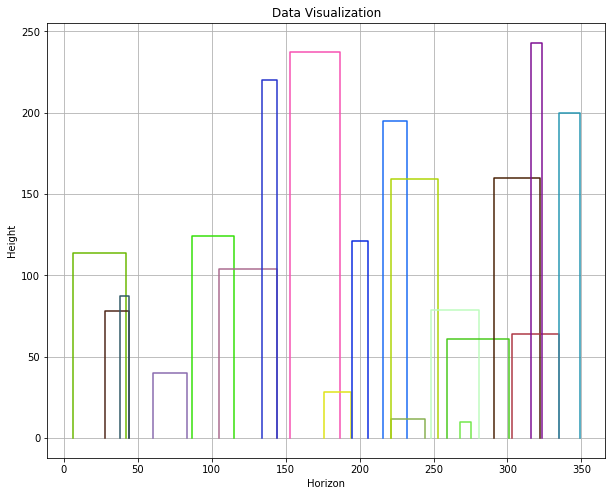

In [7]:
plot_data(buildings_data)

# Brute Force Algorithm

## Definitions

In [8]:
# Pseudocode :

# Sort the points critical points accorting to their x axis
# FOR every critical points
#     FOR every building
#         IF (the critical point is in a building) AND (the height is below the building height)
#             Raise the critical point
#
#     IF the critical point is not redundant
#         Add the critical points to the solution

def brute_force_solve(buildings_data):

    critical_points = find_critical_points(buildings_data)
    sorted_critical_points = critical_points[np.argsort(critical_points, axis=0)[:, 0]]
    
    points_to_keep = [[0,0]]
    for point in sorted_critical_points:
        for building in buildings_data:
            if point[0] > building[0] and point[0] < building[1] and point[1] < building[2]:
                point[1] = building[2]

            if point[0] < building[0]:
                break
        
        previous_point_kept = points_to_keep[-1]
        if previous_point_kept[1] != point[1]:
            if point[0] == previous_point_kept[0]:
                if point[1] > previous_point_kept[1]:
                    points_to_keep.pop()
                    points_to_keep.append(point)
                
            else :
                points_to_keep.append(point)

    points_to_keep = np.array(points_to_keep[1:])
    return points_to_keep

## Usage

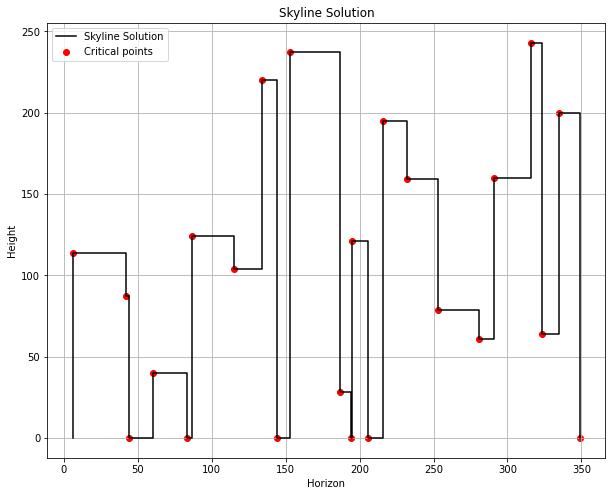

In [9]:
points_to_keep = brute_force_solve(buildings_data)
plot_solution(points_to_keep)

# Divide to Reign Algorithm

## Definitions

In [10]:
def recombine_solutions(first_group, second_group): 
    index_first_group = 0
    index_second_group = 0
    
    total_index_first_group = len(first_group)
    total_index_second_group = len(second_group)
    
    is_first_group_covered = False
    is_second_group_covered = False
    
    first_element = first_group[index_first_group]
    second_element = second_group[index_second_group]
    
    height_1 = 0
    height_2 = 0
    current_height = 0
    
    current_element = [0, 0]
    new_solution = [[0, 0]]
    
    while not(is_first_group_covered) or not(is_second_group_covered) :
        if (not(is_first_group_covered) and first_element[0] <= second_element[0]) or is_second_group_covered:
            current_element = first_element
            height_1 = current_element[1]
            
            if current_element[1] < height_2 :
                current_element[1] = height_2
            
            index_first_group += 1
            if index_first_group < total_index_first_group:
                first_element = first_group[index_first_group]
            else:
                is_first_group_covered = True
            
        elif (not(is_second_group_covered) and second_element[0] <= first_element[0]) or is_first_group_covered:
            current_element = second_element
            height_2 = current_element[1]
            
            if current_element[1] < height_1 :
                current_element[1] = height_1
            
            index_second_group += 1
            if index_second_group < total_index_second_group:
                second_element = second_group[index_second_group]
            else:
                is_second_group_covered = True
                
        else :
            print ('ERROR: IMPOSSIBLE STATE')
            break
        
        # Add the points that are not redundant
        previous_point_kept = new_solution[-1]
        if previous_point_kept[1] != current_element[1]:
            if current_element[0] == previous_point_kept[0]:
                if current_element[1] > previous_point_kept[1]:
                    new_solution.pop()
                    new_solution.append(current_element)
                
            else :
                new_solution.append(current_element)
    
    new_solution = np.array(new_solution[1:])
    return new_solution

In [11]:
# Pseudocode :

# Function Divide-to-Reign(x {Sample}) : y {solution}
#     IF is small return brute-force-algorithm(x)
#     Decompose x en 2 sub-samples x_0, x_1
#     FOR i=1 to n do :
#         yi <-- Divide-to-Reign(x_i)
#     Recombine y_n to y
#
#     RETURN y

def divide_to_reign_solve(buildings_data, recursion_threshold=1):
    
    # IF is small return brute-force-algorithm(x)
    if len(buildings_data) == max(1, recursion_threshold):
        return brute_force_solve(buildings_data)
    
    # Decompose x en 2 sub-samples x_0, x_1
    left_group = None
    right_group = None
    if len(buildings_data) % 2 == 0 :
        splited_buidings_data = np.vsplit(buildings_data[:], 2)
        left_group = splited_buidings_data[0]
        right_group = splited_buidings_data[1]
    else :
        splited_buidings_data = np.vsplit(buildings_data[:-1], 2)
        left_group = splited_buidings_data[0]
        right_group = np.vstack((splited_buidings_data[1], buildings_data[-1]))
        
    # FOR i=1 to n do : yi <-- Divide-to-Reign(x_i)
    left_solution = divide_to_reign_solve(left_group)
    right_solution = divide_to_reign_solve(right_group)
    
    # Recombine y_n to y
    solution = recombine_solutions(left_solution, right_solution)
    
    # RETURN y
    return solution

## Usage

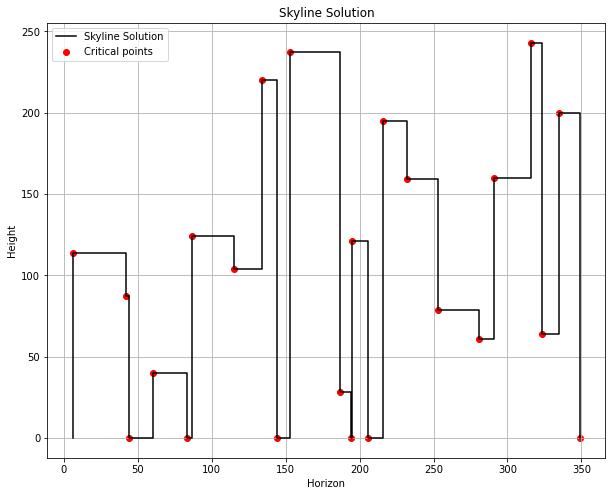

In [12]:
solution_reached = divide_to_reign_solve(buildings_data, recursion_threshold=1)
plot_solution(solution_reached)

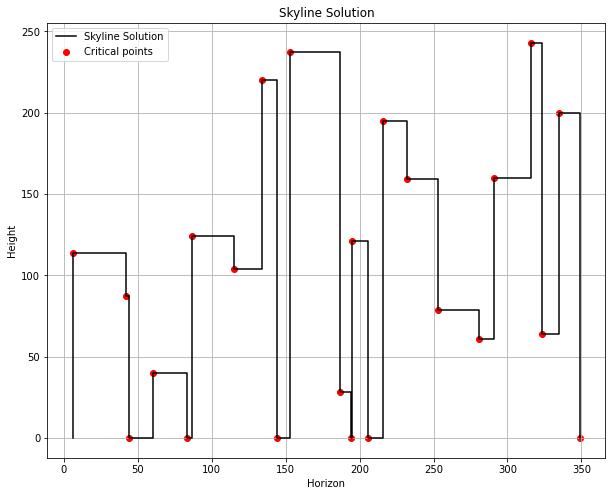

In [13]:
solution_reached = divide_to_reign_solve(buildings_data, recursion_threshold=5)
plot_solution(solution_reached)

# Script to generate python script

In [13]:
# !jupyter nbconvert --to script solution.ipynb